<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Predicting Weather from RDU's Weather Station

## Background



Our task in this exercise is to build the pipeline to convert raw data into features to use in a ML model. The model itself that you will use has already been set up for you (a linear regression model which has been put into a separate script you will import) and **you cannot change the model**, only the data pipeline.

## Data
You have been given two csv files of data to use in your analysis.  The first file ("2011-2012_bikes.csv") contains historical demand data from the past two years of operation. The dataset contains the following columns:
- dteday : date 
- hr : hour (0 to 23) 
- cnt: count of total rental bikes 

The second file ("2011-2012_weather.csv") contains weather information for the same time period.  This dataset contains the following columns:  
- dteday : date 
- hr : hour (0 to 23) 
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp : Temperature in Celsius
- atemp: Feels-like temperature in Celsius
- hum: Humidity
- windspeed: Wind speed

You may use some or all of the data provided, not all of it is necessarily useful.

## Approach
Your task in this exercise is to build the pipeline from raw data to features ready for modeling.  There are many possible approaches to doing this, some are better, some are worse.  


In [3]:
import os
import numpy as np
import pandas as pd

from src.create_combined import load_and_clean_weather

df = load_and_clean_weather()

Reading 72306-2015.csv ...
Reading 72306-2016.csv ...
Reading 72306-2017.csv ...
Reading 72306-2018.csv ...
Reading 72306-2019.csv ...
Reading 72306-2020.csv ...
Reading 72306-2021.csv ...
Reading 72306-2022.csv ...
Reading 72306-2023.csv ...
Reading 72306-2024.csv ...
Reading 72306-2025.csv ...
Final dataset: 94599 rows, 10 columns
Date range: 2015-01-01 00:00:00 → 2025-10-16 15:00:00


In [2]:
from src.data_clean import clean_data

output = clean_data(df)

os.makedirs("Data_Cleaned", exist_ok=True)
output.to_csv("Data_Cleaned/cleaned_weather_final.csv", index=False)

Reading 72306-2015.csv ...
Reading 72306-2016.csv ...
Reading 72306-2017.csv ...
Reading 72306-2018.csv ...
Reading 72306-2019.csv ...
Reading 72306-2020.csv ...
Reading 72306-2021.csv ...
Reading 72306-2022.csv ...
Reading 72306-2023.csv ...
Reading 72306-2024.csv ...
Reading 72306-2025.csv ...

Combined dataset shape: 94599 rows, 22 columns.
Columns found: ['year', 'month', 'day', 'hour', 'temp', 'temp_source', 'rhum', 'rhum_source', 'prcp', 'prcp_source', 'wdir', 'wdir_source', 'wspd', 'wspd_source', 'wpgt', 'wpgt_source', 'pres', 'pres_source', 'cldc', 'cldc_source', 'coco', 'coco_source']

---- Cleaning Data ----
Datetime column built and moved to front.
Dropped 'cldc' column due to high missingness.
Interpolated 'prcp': 6400 → 352 missing values.
Interpolated 'wdir': 1115 → 0 missing values.
Cleaned dataset has 94599 rows and 18 columns.
-----------------------
Sanity check: dropped 94599 rows with remaining NaN values.

Preview of cleaned data:
Empty DataFrame
Columns: [datetime

Fitting ensemble...


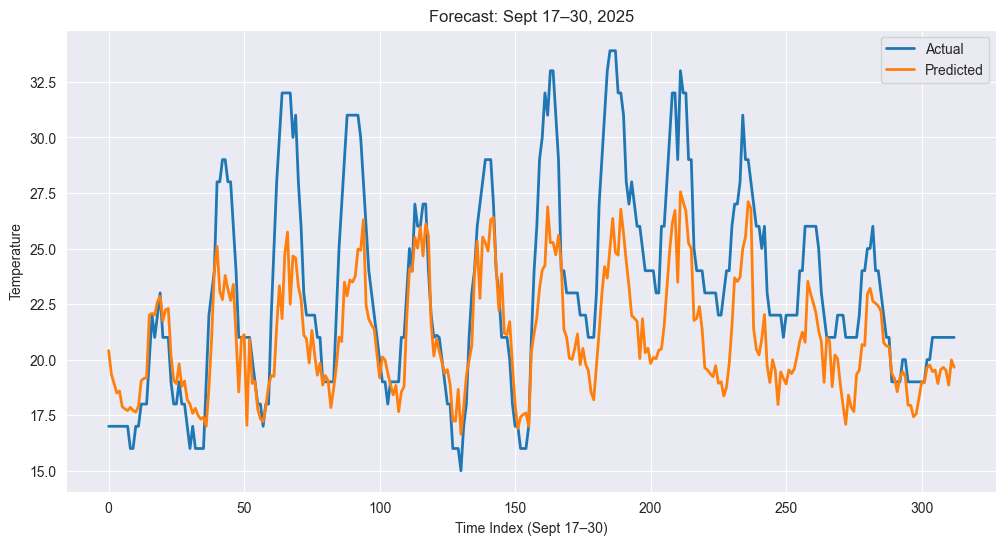

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.ensemble.model_creation import run_pipeline

# Case 1: If Sept 2025 labels exist in cleaned_weather_final.csv
X_train, y_train, X_test, y_test, model, y_pred = run_pipeline(
    weather_filename="Data_Cleaned/cleaned_weather_final.csv",
    forecast_start="2025-09-17",
    forecast_end="2025-09-30"
)

# Case 2: Only want to forecast
#_, _, X_future, _, trained_model, future_pred = run_pipeline(
#    weather_filename="Data_Cleaned/cleaned_weather_final.csv",
#    forecast_start="2025-09-17",
#    forecast_end="2025-09-30"
#)
# print("First 10 predictions:", future_pred[:10])

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.title("Forecast: Sept 17–30, 2025")
plt.xlabel("Time Index (Sept 17–30)")
plt.ylabel("Temperature")
plt.legend()
plt.show()


In [26]:
import os
import pandas as pd
from src.evaluate_predictions import evaluate_preds

os.makedirs("Data_Cleaned_Final", exist_ok=True)
file_path = "Data_Cleaned_Final/forecast_sept2025.csv"

# If a model exists, save new predictions
if "model" in locals() and model is not None:
    pred_df = pd.DataFrame({
        "actual": y_test.values,
        "predicted": y_pred
    })

    # Add datetime if available
    if hasattr(y_test, "index"):
        pred_df.insert(0, "datetime", y_test.index)

    pred_df.to_csv(file_path, index=False)
    print("Saved new forecast data to", file_path)

# Otherwise, load the last saved forecast
else:
    pred_df = pd.read_csv(file_path)
    print("Loaded existing forecast data from", file_path)

# Extract columns for evaluation
y_test = pred_df["actual"]
y_pred = pred_df["predicted"]

# Use datetime if available
time_index = pred_df["datetime"] if "datetime" in pred_df.columns else None

# Run evaluation
evaluate_preds(y_test, y_pred)

Loaded existing forecast data from Data_Cleaned_Final/forecast_sept2025.csv
Evaluation Results:
  MSE: 11.595
  RMSE: 3.405
  MAE: 2.657
  R2: 0.424


{'MSE': 11.59506060190656,
 'RMSE': np.float64(3.4051520673688804),
 'MAE': 2.6571840886090468,
 'R2': 0.4237785254462434}

Model Evaluation
Residual Summary
Mean Residual: 2.1728719444669466
Median Residual: 2.028662946696347
Residual Std Dev: 2.6259701381594516
Mean Absolute Error: 2.6571840886090468
Skewness: 0.45092220967133734
Kurtosis: -0.23518009855237842


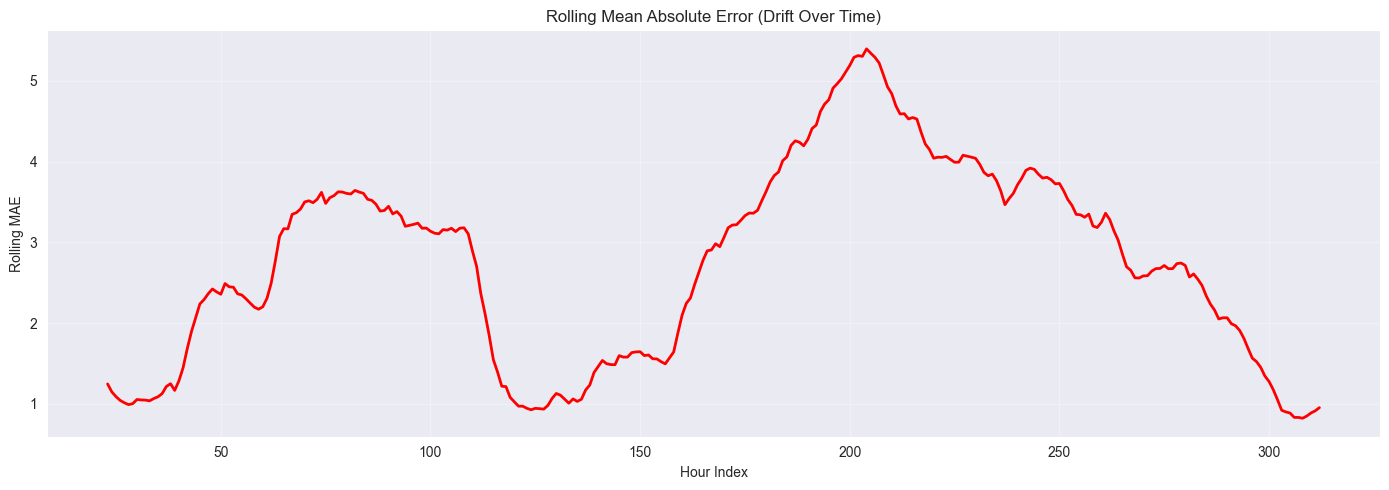

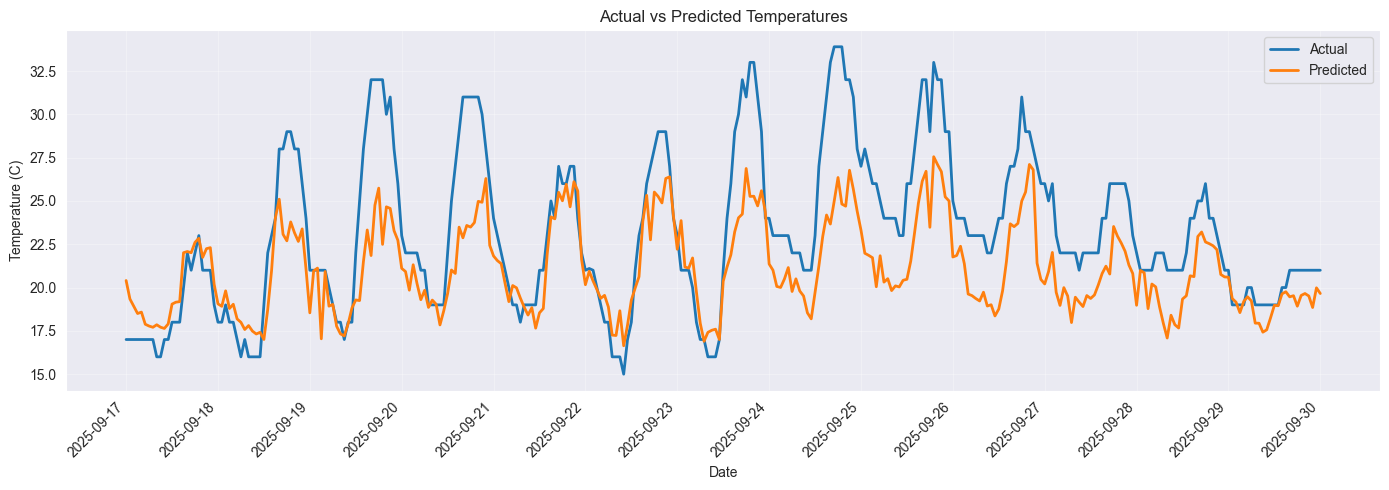

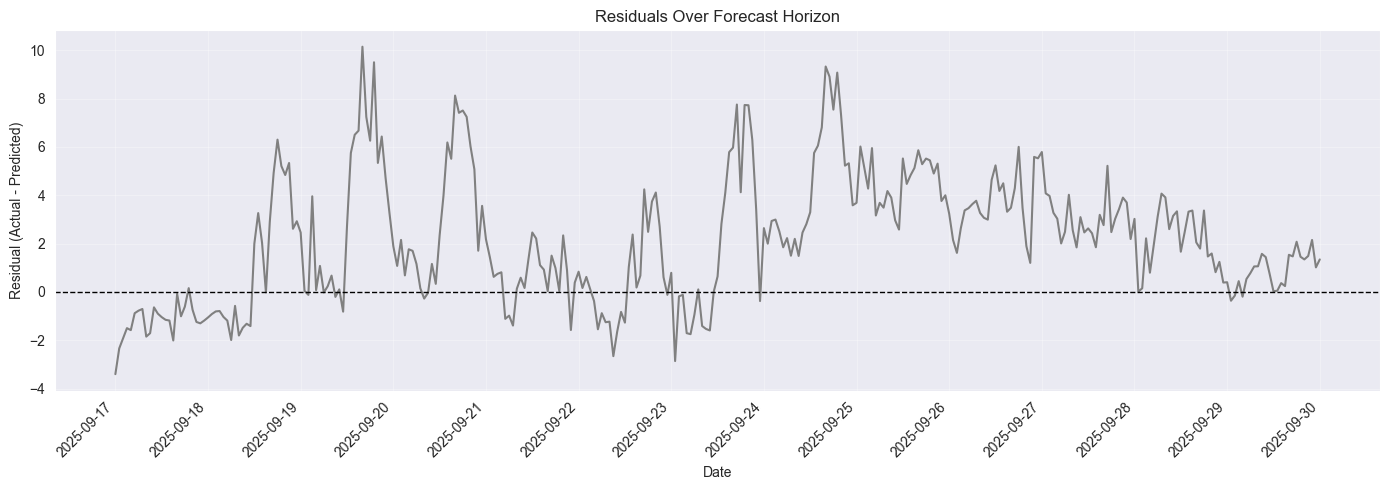

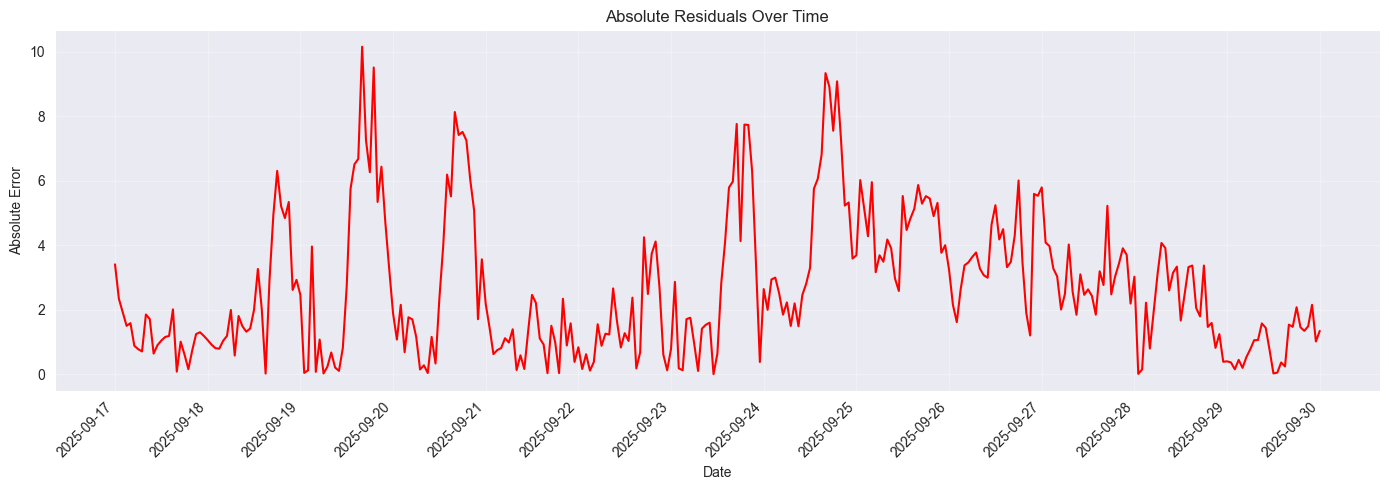

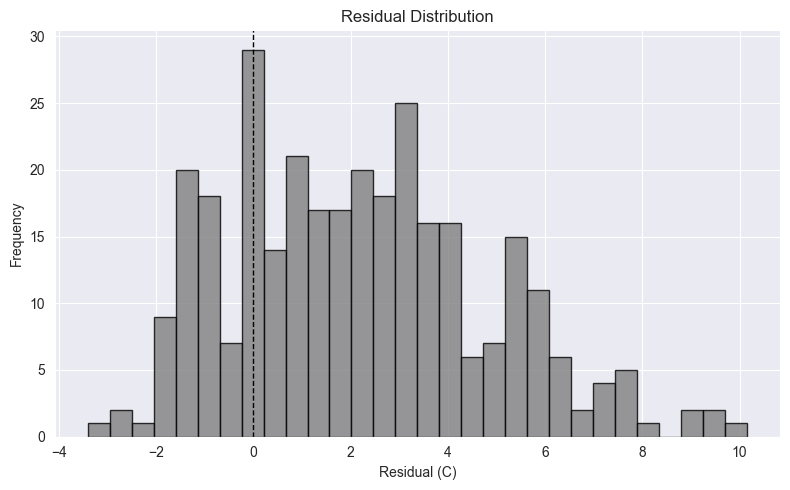

In [22]:
import pandas as pd
import importlib
import src.residuals
importlib.reload(src.residuals)
from src.residuals import model_eval, graph_making

df = pd.read_csv("Data_Cleaned_Final/forecast_sept2025.csv")

time_index = df["datetime"] - 93886
## This corresponds when we initially selected the data starting in 2015 but we can just start at a new 0.
y_test = df["actual"]
y_pred = df["predicted"]

# Evaluate and plot
residuals = model_eval(y_test, y_pred, time_index)
graph_making(y_test, y_pred, time_index)


### Load data

Evaluation Results:
  MSE: 11.595
  RMSE: 3.405
  MAE: 2.657
  R2: 0.424

Create and run a function `load_data()` to do your data loading and any merging needed.  You can specify the arguments and returns as needed.

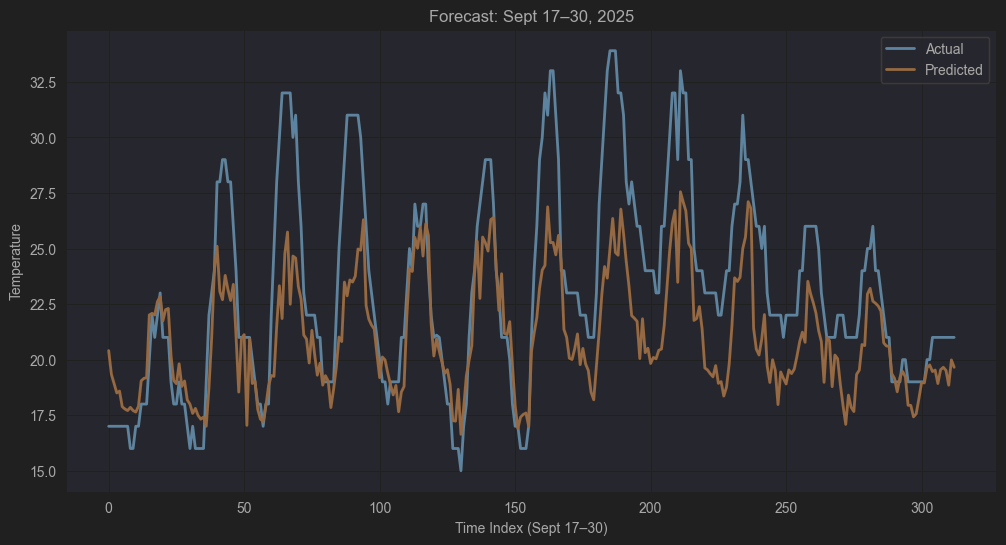

In [81]:
def load_data(file1, file2):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    merged = pd.merge(df1, df2, how="outer", on=['dteday','hr'])
    return merged

### Clean data
Use the cell below to create and run a function `clean_data()` which cleans up the data as needed.  Things you may want to consider at this stage include:  
- Checking for and handling any missing values 
- Identifying any erroneous data and handling 
- Identifying outliers and determining whether to remove/adjust them or leave them as-is
- Etc.

In [82]:
def clean_data(s1):
    # Standardize dates
    s1['dteday'] = pd.to_datetime(s1['dteday'], errors='coerce')

    # Convert to epoch seconds
    s1['dteday'] = (s1['dteday'] + pd.to_timedelta(s1['hr'], unit='h')).astype('int64') // 10**9

    # Forcing Data into numeric if not already
    for col in s1.columns[1:]:
        s1[col] = pd.to_numeric(s1[col], errors='coerce')

    # Dropping non-numerics
    s2 = s1.dropna()

    print("Dropped " + str(len(s1)-len(s2)) + " rows from our dataset due to missing values.")

    # Remove extrema
    numeric_cols = s2.iloc[:, 2:]
    s3 = s2.copy()

    for col in numeric_cols.columns:
        # Get the Series
        series = s2[col]

        # Calculate mean and std
        col_mn = series.mean()
        col_st = series.std()

        # Mask rows within 2 std
        keep_col = (series > col_mn - 2 * col_st) & (series < col_mn + 2 * col_st)

        # Drop rows outside this range
        s3 = s3[keep_col]
    print("Dropped " +str(len(s2)-len(s3))+ " columns due to extrema")

    s4 = s3.drop(columns=['hr'])

    return s4

### Split data for training and testing
Create and run the function `split_data()` in the cell below to split the data into training and test sets.  You should use all data up to and including July 31 2012 as the training set, and the data for the period August 1 2012 - December 31 2012 as the test set.

In [83]:
def split_data(s1):
    # Define cutoff
    cutoff = int(pd.to_datetime("2012-08-01 00:00:00").timestamp())

    before = s1[s1['dteday'] <= cutoff]
    after  = s1[s1['dteday'] > cutoff]

    target = 'cnt'

    # Split into X and y
    X_train = before.drop(columns=[target])
    y_train = before[target]

    X_test = after.drop(columns=[target])
    y_test = after[target]

    return X_train, y_train, X_test, y_test


### Feature Engineering
Create and run the function `build_features()` below to create any additional derivative features (e.g. time series features) that you wish to use in modeling.  You will need to apply this function to both your training and test sets.

### Feature Selection
Use the cell below to create and run the function `feature_select()` which performs feature selection using univariate (filter) methods.  After you analyze the correlations, determine whether you would like to remove any features and do so.

### Prepare Features for Modeling
Our final step in the pipeline is to prepare our feature set for modeling.  In particular, in this step we need to ensure that any categorical variables we may be using are encoded as numeric values in order for the model to function properly.  You might also consider scaling some of your data.

In the below cell create and run a function `prepare_train_feats()` which prepares the training features.

We also need to prepare the features in our test set in the same way to feed into the model.  Use the cell below for the function `prepare_test_feats()` which prepares your test set features.

### Run pipeline
Finally, let's bring everything together in a function to run the entire pipeline for our training data.  Complete the function `run_pipeline()` in the cell below.  The function should call any/all of the functions you have defined above which are needed to load the data, transform it and prepare the features for both the training set and the test set.

In [84]:
def run_pipeline(bike_filename, weather_filename):
    '''
    Runs your pipeline (calling the above functions as needed) to transform the raw data into the training and test data sets for modeling

    Inputs:
        bike_filename(str): name of the file containing the bike data
        weather_filename(str): name of the file containing the weather data

    Returns:
        X_train(pd.DataFrame): dataframe containing the training set inputs
        y_train(pd.DataFrame): dataframe containing the training set labels
        X_test(pd.DataFrame): dataframe containing the test set inputs
        y_test(pd.DataFrame): dataframe containing the test set labels
    '''
    merged = load_data(bike_filename,weather_filename)
    clean = clean_data(merged)
    X_train, y_train, X_test, y_test = split_data(clean)

    return X_train, y_train, X_test, y_test

    

Now that we've prepared our features we are ready to run our model.  Run the cell below, which trains the model on the training set and calculates and reports the mean squared error (MSE) on the test set.  If everything went well you should have a MSE below 18500

In [85]:
bike_datafile = "2011-2012_bikes.csv"
weather_datafile = "2011-2012_weather_messy.csv"
X_train, y_train, X_test, y_test = run_pipeline(bike_datafile, weather_datafile)
mse_score = run_model(X_train, y_train, X_test, y_test)
print('Mean Squared Error on the test set: {:.2f}'.format(mse_score))

assert mse_score < 18500

Dropped 58 rows from our dataset due to missing values.
Dropped 3416 columns due to extrema
Mean Squared Error on the test set: 17888.35
